<a href="https://colab.research.google.com/github/sanganalasya-hash/Data-Science/blob/main/Copy_of_Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying each of: polynomial modeling, b splines, and GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

They work better when the data has a more complicated relationship. It allows models to capture nonlinear, changing trends that can show different relationship between the variables.

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

If predictions stop getting better, no need to increase complexity in your model. Overall, simple models are better. They are easier to interpret, faster to run, and avoid overfitting.

**Task3**:

What's the point of using b splines?

They get the flexibility of polynomial with less overfitting. Similar to polynomial models, they allow you to fit nonlinear and complex relationships.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

It assigns probability based on smoothness? I think based on the notes I understand that it determines how different data points influnece each other. So like eveery data point affects the other data points.

**Task5**:

Fit three models to the howell data (from Unit5ExercisesSF): polynomial, b splines, and Gaussian Process.

Plot the posterior predictive check on a scatter plot, as is standard/required.

Hint: Distributional models (variable variance) work better on the howell data.


In [ ]:
!pip install preliz
!pip install bambi

In [2]:

import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz
import pymc as pm
import bambi as bmb

In [3]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:

#degree 4 polynomial model
model_poly_4 = bmb.Model("weight ~ poly(height, degree=3)", howell, family="negativebinomial")
idata_poly_4 = model_poly_4.fit()

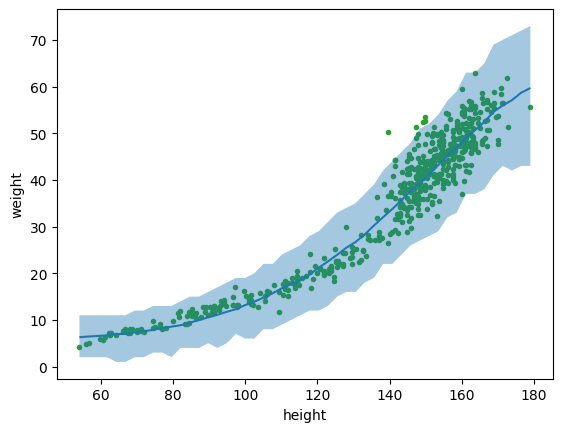

In [ ]:
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "height", pps=True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [ ]:
num_knots = 6
knots = np.linspace(howell['height'].min(), howell['height'].max(), num_knots+2)[1:-1]
model_spline = bmb.Model("weight ~ bs(height, degree=3, knots=knots)", howell, family="negativebinomial")
idata_spline = model_spline.fit()

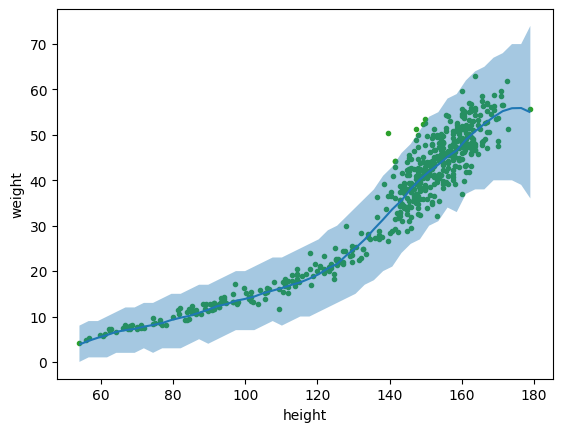

In [ ]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "height", pps= True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [7]:

#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(howell['height']))
}

priors = {
    "hsgp(height, m=168, c=8.0)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("weight ~ 0 + hsgp(height, m=168, c=8.0)", howell, family="negativebinomial", priors=priors)
idat_hsb = model_hsb.fit()

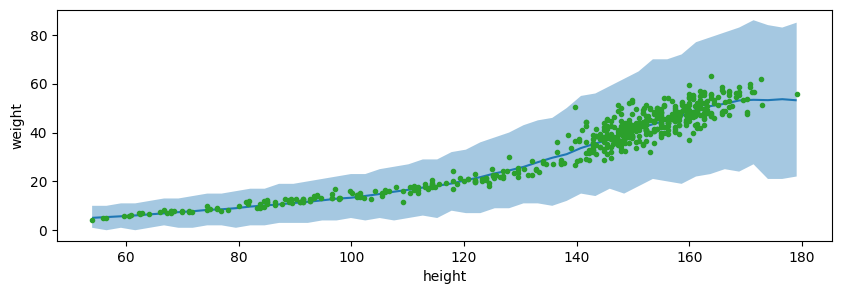

In [14]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idat_hsb, ["height"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(howell["height"].values, howell["weight"].values, "C2.")

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand much in this article--I had to read it about five times before I figured out what was going on. The points of this task are to: hammer home that good GP implementations are extremely technical, and increasure your exposure to the kinds of problems traditional GPs are good at solving.

GPs are really helpful when you're uncertain about a model. For example, in the ice core example, they were to place priors on the time because they didn't know that as well. So you're able to like have uncertainty in the predictors as well.

**Task7**:

Describe your favorite graph from the article in the previous task with as much technical detail as you can muster.

Explain why its your favorite.

I like the fit and possible forecasts graph. I like how cool the posterior looks and how it zigzags. I think it does a good job at predicting the trend and it's pretty satisfying to see